# Data Science Residency Project
### Ekim Luo
*Aug 20, 2021*

This project is based on the [nilearn example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) on classifying age using functional connectivity. They found that tangent embedding was the best way to classify age groups based on functional connectivity. In this notebook, the same classifier is applied to [The Stockholm Sleepy Brain](https://openneuro.org/datasets/ds000201/versions/1.0.2) resting-state functional data, specifically to classify sex (female v. male) and age group (young v. old) with an increased test sample size (n = 10 instead of n = 5).  

# The Stockholm Sleepy Brain Project
The Stockholm Sleepy Brain project aimed to investigate the overall effect of sleepiness on emotional processing. See [Tamm et al. 2017](https://www.nature.com/articles/s41598-017-12098-9) for a paper produced from this dataset. 
- Version 1.0.2 (4.24.2019)
- Source: [OpenNeuro](https://openneuro.org/datasets/ds000201/versions/1.0.2/download)
- The dataset was downloaded using AWS. Only 38 subject folders are downloaded. 

## **Load data**

In [1]:
import glob

files = glob.glob('/home/ekim/Residency_2021/sleepy_fMRI/*/ses-1/func/*.nii.gz')

In [2]:
print('There are a total of {} zipped nifti files.'.format(len(files)))
print('\nExample of file path:\n',files[1])

There are a total of 182 zipped nifti files.

Example of file path:
 /home/ekim/Residency_2021/sleepy_fMRI/sub-9004/ses-1/func/sub-9004_ses-1_task-sleepiness_bold.nii.gz


If needed, unzip data files. The nilearn tutorial directly uses `.gz` files, so I'm skipping this step. 
*Source: [stackoverflow](https://stackoverflow.com/questions/31028815/how-to-unzip-gz-file-using-python)*
```python
import gzip
import shutil

for file in files:
    with gzip.open(file,'rb') as f_in:
        with open(file[:-3], 'wb') as f_out: # remove .gz extension
            shutil.copyfileobj(f_in, f_out)
```

Use `glob.glob` again to get a list of unzipped files. 

### Check file types.

In [3]:
# store file names
filenames = []
for filename in files:
    filenames.append(filename.split('/')[-1:])
print('There are a total of {} file names.'.format(len(filenames)))
print('\nExample of file name:\n',filenames[10])

There are a total of 182 file names.

Example of file name:
 ['sub-9019_ses-1_task-arrows_bold.nii.gz']


#### Flatten list within list.
*Source: [stackoverflow](https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists)*

In [4]:
# flatten list within list
def flatten(t):
    return [item for sublist in t for item in sublist]

filenames_flat = flatten(filenames)

In [5]:
# get file types
filenames_flat[1].split('-')[-1:]
filetype = []
for filename in filenames_flat:
    filetype.append(filename.split('-')[-1:])
filetype_flat = flatten(filetype)

In [6]:
# check file types
import pandas as pd 

pd.DataFrame(filetype_flat, columns = ['filetype']).filetype.value_counts()

rest_bold.nii.gz          38
faces_bold.nii.gz         37
hands_bold.nii.gz         37
sleepiness_bold.nii.gz    35
arrows_bold.nii.gz        35
Name: filetype, dtype: int64

### Check unique subjects.

In [7]:
subjects = []

for subject in filenames_flat:
    subjects.append(subject.split('_')[0])

print('There are a total of {} subjects. Their functional data from session 1 will be analyzed.'.format(pd.DataFrame(subjects, columns = ['subjectID']).subjectID.nunique()))

There are a total of 38 subjects. Their functional data from session 1 will be analyzed.


## Get data information

### README

In [8]:
with open('README', 'r') as f:
    readme = f.read()

In [9]:
import re
pattern = r'\##(.*?)\##'
readme_headings = re.findall(pattern, readme)

print('The readme file contains information on {}'.format([heading for heading in readme_headings]))

The readme file contains information on [' Background and Aim ', ' Method and Design ', ' Specific Notes ', '# participants.tsv File ', '# BIDS dataset ', '# derivatives Folder ', '# sourcedata Folder ', '# Diffusion Imaging - use these data with caution ', '# Raw Polysomnography Data ', '# Known Issues ']


### dwi

In [10]:
# dwi
import json
from pprint import pprint

with open('dwi.json', 'r') as f:
    dwi = json.load(f)

pprint(dwi)

{'AcquisitionDuration': 357.000096,
 'EchoTrainLength': 1,
 'EffectiveEchoSpacing': 0.632,
 'FlipAngle': 90,
 'GEImageTypeRIMPCode': 0,
 'ImageType': 'ORIGINAL/PRIMARY/OTHER',
 'InplanePhaseEncodingDirection': 'COL',
 'InversionTime': 0,
 'MRAcquisitionType': '2D',
 'MagneticFieldStrength': 3,
 'Manufacturer': 'GE MEDICAL SYSTEMS',
 'ManufacturersModelName': 'DISCOVERY MR750',
 'NumberOfAverages': 1,
 'NumberOfEPIShots': 1,
 'NumberOfEchoes': 1,
 'ParallelImagingReductionFactors': [0.5, 1],
 'PercentPhaseFieldOfView': 100,
 'PhaseEncodingDirection': 'j',
 'ReceiveCoilName': '8HRBRAIN',
 'RepetitionTime': 7,
 'SATFatWaterBone': 1,
 'ScanningSequence': ['EP', 'RM'],
 'SequenceVariant': 'NONE',
 'SliceThickness': 2.3,
 'SpacingBetweenSlices': 2.3,
 'TotalReadoutTime': 0.024648}


### Participants
- The codebook with variables collected and what they mean are in the `participants.json` file. 
- Participant data are in the `participants.tsv` file.

In [11]:
# codebook
with open('participants.json', 'r') as f:
    codebook = json.load(f)
variables = pd.DataFrame(codebook).melt()
print('There are a total of {} unique variables.'.format(variables.variable.nunique()))

There are a total of 106 unique variables.


In [12]:
# export codebook
#variables.to_excel('variables_sleepy_fmri.xlsx')

In [13]:
# participant data
with open('participants.tsv') as f:
    rd = pd.read_csv(f, delimiter = '\t')
participants = pd.DataFrame(rd)
participants.head()

,participant_id,Sex,AgeGroup,BMI1,BMI2,EducationLevel,HADS_Anxiety,HADS_Depression,ISI,KSQ_SleepQualityIndex,...,PPIR_IR15,PPIR_IR40,BADD_Total,BADD_Activation,BADD_Attention,BADD_Effort,BADD_Affect,BADD_Memory,Sl_cond,Trial
0,sub-9001,Male,Young,"19,78997095","19,78997095",Studerar för närvarande på universitet/högskola,0,1,12,"4,75",...,11.0,29.0,16.0,6.0,2.0,2.0,6.0,0.0,2,B
1,sub-9002,Male,Old,"21,79944511","21,46915048",Har avslutat gymnasieskolan,2,3,9,"5,5",...,10.0,32.0,33.0,5.0,8.0,6.0,8.0,6.0,2,B
2,sub-9003,Male,Old,"20,49861496","20,49861496",Har examen från universitet/högskola,2,3,10,"5,25",...,12.0,26.0,13.0,4.0,4.0,4.0,1.0,0.0,1,B
3,sub-9004,Female,Old,"22,94811574","22,94811574",Har examen från universitet/högskola,1,2,11,"4,25",...,10.0,28.0,24.0,3.0,7.0,5.0,6.0,3.0,1,B
4,sub-9005,Male,Old,"24,75546432","24,75546432",Har avslutat gymnasieskolan,0,0,9,6,...,8.0,28.0,30.0,9.0,5.0,7.0,3.0,6.0,2,B


In [14]:
# subset df and convert to list 
# for computing region signals and extracting participant information
participants_s = participants[['participant_id','Sex', 'AgeGroup']]
participants_s = list(participants_s.itertuples(index = False, name = None))

### T1-weighted images

In [15]:
# t1w
with open('T1w.json', 'r') as f:
    t1w = json.load(f)
print('The T1-weighted file contains information on',t1w.keys())

The T1-weighted file contains information on dict_keys(['Columns', 'EchoTime', 'EchoTrainLength', 'FieldOfView', 'FlipAngle', 'ImageType', 'InplanePhaseEncodingDirection', 'InversionTime', 'MRAcquisitionType', 'MagneticFieldStrength', 'Manufacturer', 'ManufacturersModelName', 'NumberOfAverages', 'NumberOfEPIShots', 'NumberOfEchoes', 'NumberOfSlices', 'ParallelImagingReductionFactors', 'PercentPhaseFieldOfView', 'PhaseEncodingDirection', 'PixelBandwidth', 'PixelSpacing', 'ReceiveCoilName', 'RepetitionTime', 'Rows', 'SATFatWaterBone', 'ScanOptions', 'ScanningSequence', 'SequenceVariant', 'SeriesDescription', 'SeriesNumber', 'SliceThickness', 'SpacingBetweenSlices'])


### T2-weighted images

In [16]:
with open('T2w.json', 'r') as f:
    t2w = json.load(f)
print('The T2-weighted file contains information on',t2w.keys())

The T2-weighted file contains information on dict_keys(['Columns', 'EchoTrainLength', 'FieldOfView', 'FlipAngle', 'GEImageTypeRIMPCode', 'ImageType', 'InplanePhaseEncodingDirection', 'MRAcquisitionType', 'MagneticFieldStrength', 'Manufacturer', 'ManufacturersModelName', 'NumberOfAverages', 'NumberOfEPIShots', 'NumberOfEchoes', 'NumberOfSlices', 'ParallelImagingReductionFactors', 'PercentPhaseFieldOfView', 'PhaseEncodingDirection', 'PixelBandwidth', 'PixelSpacing', 'ReceiveCoilName', 'RepetitionTime', 'Rows', 'SATFatWaterBone', 'ScanOptions', 'ScanningSequence', 'SequenceVariant', 'SeriesDescription', 'SliceThickness', 'SpacingBetweenSlices'])


# Classification of sex using functional connectivity

*Source: [Nilearn: statistics for neuroimaging in Python](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html)*

This example compares different kinds of functional connectivity between regions of interest:
- correlation
- partial correlation
- tangent space embedding

The resulting connectivity coefficients can be used to discriminate females from males. In general, the tangent space embedding outperforms the standard correlations: see [Dadi et al (2019)](https://www.sciencedirect.com/science/article/abs/pii/S1053811919301594) for a careful study. 

## Retrieve resting-state functional data.

In [17]:
rest = []
for i in files:
    if 'rest' in i:
        rest.append(i)
print('Example of rs functional data file:',rest[5])

Example of rs functional data file: /home/ekim/Residency_2021/sleepy_fMRI/sub-9011/ses-1/func/sub-9011_ses-1_task-rest_bold.nii.gz


## Load ROIs from MSDL brain atlas.

Use probabilistic regions of interest (ROIs) from the **multi-subject dictionary learning (MSDL) atlas**.

The **MSDL atlas** extrapolates a population-level spatial maps from subject-level maps. Use [`nilearn.datasets.fetch_atlas_msdl`](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_msdl.html#nilearn.datasets.fetch_atlas_msdl) to download and load the MSDL brain atlas. 
- Specify directory path for data storage using the `data_dir` paramter. This returns data of an [`sklearn Bunch`](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch) object.

In [18]:
from nilearn import datasets

msdl_data = datasets.fetch_atlas_msdl(data_dir = 'TUT_DATA_fmri_development_nilearn')
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)

print('MSDL has {0} ROIs, part of the following networks: \n{1}.'.format(n_regions, msdl_data.networks))

MSDL has 39 ROIs, part of the following networks: 
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


/home/ekim/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
/home/ekim/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


## Region signals extraction
To extract regions time series, we instantiate a `nilearn.input_data.NiftiMapsMasker` object and pass the atlas the file name to it as well as filtering band-width and detrending option. 

[`nilearn.input_data.NiftiMapsMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMapsMasker.html#nilearn.input_data.NiftiMapsMasker) is a class for masking Niimg-like objects. NiftiMapsMasker is useful when data from overlapping volumes should be extracted (as opposed to what NiftiLabelsMasker does). Use it to summarize brain signals from large-scale networks obtained *prior to* PCA or ICA. 

In [19]:
from nilearn import input_data

masker = input_data.NiftiMapsMasker(
msdl_data.maps, resampling_target = 'data', t_r = 2, detrend = True,
low_pass = .1, high_pass = .01
#memory = 'nilearn_cache', memory_level = 1
).fit()

/home/ekim/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1054: FutureWarning: The parameter "sessions" will be removed in 0.9.0 release of Nilearn. Please use the parameter "runs" instead.
  data = signal.clean(


**NiftiMapsMasker**
- `resampling_target`: specify which image gives the final shape/size. Default is `data`. 
- `t_r`, `detrend`, `low_pass`, `high_pass`: passed to signal.clean. 
- `memory`: used to cache the region extraction process. By default, no caching is done. If a string is given, this is the path to the caching directory. 
- `memory_level`: aggressiveness of memory caching. The higher the number, the higher the number of functions that will be cached.

This function returns a 2D numpy.ndarray with the shape of (N scans, N maps), and represents the signal for each map. 

Compute region signals and extract useful phenotypic information.

In [20]:
# check column unique values
participants.Sex.unique()

array(['Male', 'Female'], dtype=object)

In [21]:
females = []
pooled_subjects_sex = []
groups_sex = []

for func_file, participant in zip(rest, participants_s):
    time_series = masker.transform(func_file)
    pooled_subjects_sex.append(time_series)
    if participant[1] == 'Female': # sex is at column index 1
        females.append(time_series)
    groups_sex.append(participant[1])

In [22]:
print('Data has {0} females.'.format(len(females)))

Data has 18 females.


## ROI-to-ROI correlations of females
A simple and common way to look at connectivity is correlation. It models the full (marginal) connectivity between pairwise ROIs. 

We can estimate it using [`nilearn.connectome.ConnectivityMeasure`](https://nilearn.github.io/modules/generated/nilearn.connectome.ConnectivityMeasure.html#nilearn.connectome.ConnectivityMeasure). This class computes different kinds of functional connectivity matrices. 
- Use the `kind` parameter to specify the matrix kind. Default is covariance. Other options include correlation, partial correlation, tangent, and precision. 

In [23]:
from nilearn.connectome import ConnectivityMeasure

# instantiate connectivity measure
correlation_measure = ConnectivityMeasure(kind = 'correlation')

From the list of ROIs time-series for females, the `ConnectivityMeasure` (instantiated as `correlation_measure`) computes individual correlation matrices.

In [24]:
correlation_matrices = correlation_measure.fit_transform(females)

# all individual coefficients are stacked in a unqiue 2D matrix
print('Correlations of females are stacked in an array of shape {0}'.format(correlation_matrices.shape),'\n')
print('Example of matrix:\n',correlation_matrices[1][1])

Correlations of females are stacked in an array of shape (18, 39, 39) 

Example of matrix:
 [ 0.65631294  1.          0.01530595 -0.30533603  0.72161956  0.49507262
 -0.10173946  0.08420038  0.64971156  0.35640771  0.36857923  0.3297531
 -0.66027684  0.70761635  0.0065924   0.26586103  0.58011205 -0.52883882
 -0.47050475  0.10339301 -0.0572829  -0.28997984  0.43581639  0.67481079
  0.54161649  0.6951902   0.39239541  0.3432187   0.44694408  0.30848236
  0.71677474  0.66511335  0.63990103  0.74635924  0.25049695  0.46840256
  0.30212734  0.72610464 -0.71795002]


`ConnectivityMeasure` (instantiated as `correlation_measure` can also be used to compute mean correlation across **all fitted subjects** by using the `mean_` attribute. 

In [25]:
mean_correlation_matrix = correlation_measure.mean_

print('Mean correlation has shape {0}'.format(mean_correlation_matrix.shape),'\n')
print('Example of mean correlation matrix:\n',mean_correlation_matrix[1])

Mean correlation has shape (39, 39) 

Example of mean correlation matrix:
 [ 0.58828077  1.          0.31415683 -0.075562    0.52597126  0.06282938
  0.20996771 -0.31370471  0.52062365  0.60834147  0.40721645  0.12862365
 -0.34260608  0.31822859  0.00642705  0.43529112  0.28630846 -0.05144906
 -0.1079064   0.13012684 -0.02894608  0.02264982  0.35747541  0.36520453
  0.41887426  0.32751519  0.46568779  0.09323242  0.29492839  0.44921526
  0.47951779  0.44175625  0.2914048   0.20997191  0.23205864  0.43676939
  0.3308016   0.14079609  0.10481352]


Display the connectome matrices of the first 3 females. Use [`subplots`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) from `matplotlib` to create a figure and a set of subplots. This utility wrapper makes it convenient to create common layouts of subplots in a single call. 

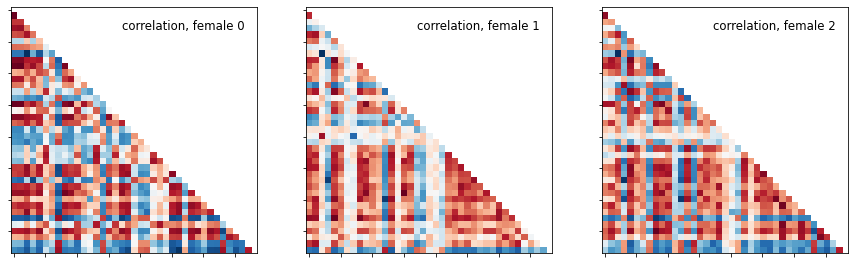

In [26]:
from nilearn import plotting
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 3, figsize = (15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri = 'lower', 
                         colorbar = False, 
                         axes = ax,
                         title = 'correlation, female {}'.format(i))

Now, display the mean correlation matrix of **all females** as a functional connectome (i.e. collective set of functional connections in the brain). Use [`nilearn.plotting.plot_connectome`](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html#nilearn.plotting.plot_connectome) to plot connectome on top of brain glass schematics. The plotted image should be in MNI space for this function to work properly. 

**MNI space**: a template used to define the boundaries around the brain, expressed in millimeters and from a set origin. Using different templates may cause certain coordinate to end up in a different anatomical structure. This generally doesn't matter in fMRI scans on an averge 3T scanner.

*Source: [LEAD-DBS](https://www.lead-dbs.org/about-the-mni-spaces/)*

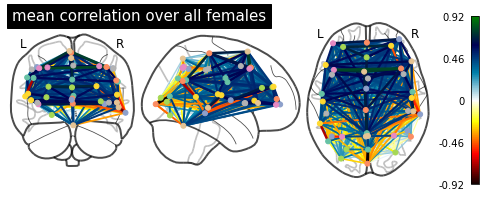

In [27]:
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         node_size = 25,
                         colorbar = True,
                         edge_cmap = 'ocean_hot_r',
                         title = 'mean correlation over all females');

plt.savefig('functional connectome (full cor)_sex.png')

- `edge_cmap`: check matplotlib **[colormaps](https://nilearn.github.io/auto_examples/01_plotting/plot_colormaps.html)** in Nilearn.
- `node_size`: specify the size of nodes. Default = 50. 
- `colorbar`: display a colorbar of correlations on the right of the plots. Default = False. 

## Studying partial correlations
- We can also study direct connections revealed by partial correlation coefficients. 
- Do this using the `kind` parameter in `ConnectivityMeasure`. 

In [28]:
# instantiate ConnectivityMeasure
partial_correlation_measure = ConnectivityMeasure(kind = 'partial correlation')

# fit measure to females data
partial_correlation_matrices = partial_correlation_measure.fit_transform(females)

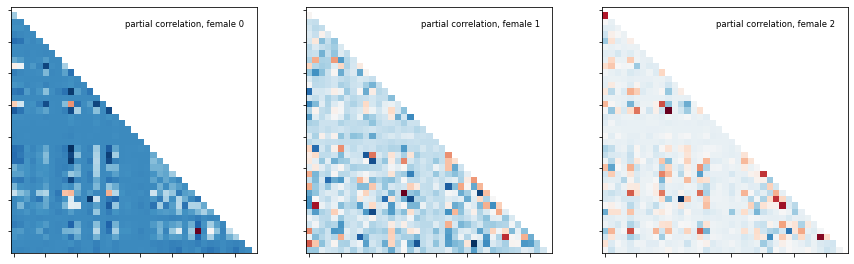

In [29]:
# plot correlation maps
_, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri = 'lower', 
                         colorbar = False, 
                         axes = ax,
                         title = 'partial correlation, female {}'.format(i))

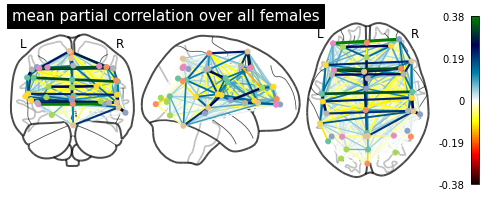

In [30]:
plotting.plot_connectome(partial_correlation_measure.mean_, msdl_coords,
                         node_size = 25,
                         colorbar = True,
                         edge_cmap = 'ocean_hot_r',
                         title = 'mean partial correlation over all females');

plt.savefig('functional connectome (partial cor)_sex.png')

## Extract subjects variabilities around a group connectivity
- We can use both full correlations and partial correlations to capture reproducible connectivity patterns at the group level. This is done using **tangent space embedding**. 

In [31]:
# instantiate ConnectivityMeasure
tangent_measure = ConnectivityMeasure(kind = 'tangent')

Fit females group and get the group connectivity matrix stored as means in `tangent_measure.mean_` and individual deviation matrices of each subject from it.

In [32]:
# fit to data
tangent_matrices = tangent_measure.fit_transform(females)

`tangent_matrices` model individual connectivities as **perturbations** of the group connectivity matrix (`tangent_measure.mean_`). These subject-to-group variability matrices do not directly reflect individual brain connections. For instance, negative coefficients can't be interpreted as anticorrelated regions. 

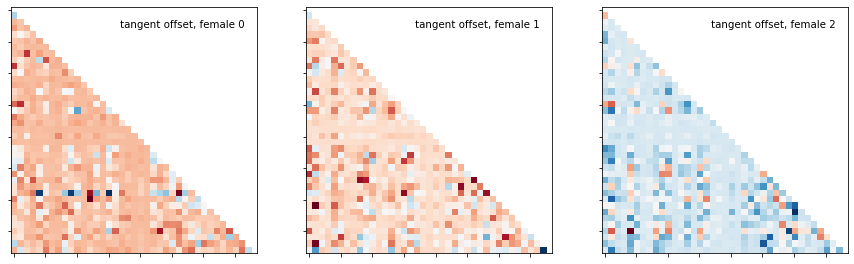

In [33]:
# plot
_, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, 
                         tri='lower', 
                         colorbar=False, 
                         axes=ax,
                         title='tangent offset, female {}'.format(i))

The mean tangent matrix can't be interpreted because individual matrices represent **deviations from the mean**, which is set to 0.  

## What kind of connectivity is most powerful for classfication?
- We will use connectivity matrices as features to distinguish females from males. 
- Use cross-validation and measure classification accuracy to compare the different kinds of connectivity matrices. 
- Use random splits of the subjects into training/testing sets. 
- [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit), a cross validator from `sklearn`, allows preventing the proportion of females in the test set.

In [34]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import numpy as np

In [35]:
_, classes = np.unique(groups_sex, return_inverse = True)

cv = StratifiedShuffleSplit(n_splits = 15, # n of reshuffling & splitting iterations
                            random_state = 0, # controls the randomness of training & testing indices produced
                            # if float, proportion of dataset to include in the train split
                            # if int, absolute n of train samples
                            test_size = 10)

# transform list into np ndarray
pooled_subjects_sex = np.asarray(pooled_subjects_sex)

/home/ekim/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [36]:
kinds = ['correlation', 'partial correlation', 'tangent']
scores = {}

for kind in kinds:
    # dictionary scores 
    # key is kind, value is empty 
    scores[kind] = []
    # cv was instantiated earlier as StratifiedShuffleSplit
    for train, test in cv.split(pooled_subjects_sex, classes):
        # ConnectivityMeasure can output the estimated subjects coefficients
        # as 1D arrays through the parameter vectorize
        connectivity = ConnectivityMeasure(kind = kind, 
                                           vectorize = True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects_sex[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(connectivity.transform(pooled_subjects_sex[test]))
        # store the accuracy for this cross validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

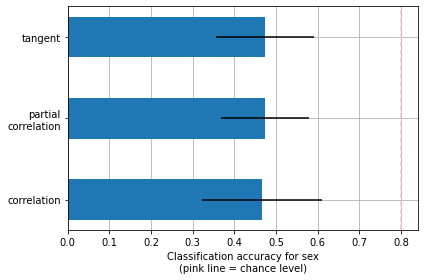

In [37]:
# display the results
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize = (6, 4))
positions = np.arange(len(kinds))*.1 + .1
plt.barh(positions, mean_scores, align = 'center', height = .05, xerr = scores_std)
yticks = [k.replace(' ','\n') for k in kinds]
plt.yticks(positions, yticks)

# set current axes
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color = 'pink', linestyle = '--')

plt.xlabel('Classification accuracy for sex\n(pink line = chance level)')
plt.tight_layout() # adjust padding between and around subplots

# Classification of age group using functional connectivity
**Age group**
- Young: 20-30 years old at time of experiment.
- Old: 65-75 years old at time of experiment.

## Region signals extraction
To extract regions time series, we instantiate a `nilearn.input_data.NiftiMapsMasker` object and pass the atlas the file name to it as well as filtering band-width and detrending option. 

[`nilearn.input_data.NiftiMapsMasker`](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMapsMasker.html#nilearn.input_data.NiftiMapsMasker) is a class for masking Niimg-like objects. NiftiMapsMasker is useful when data from overlapping volumes should be extracted (as opposed to what NiftiLabelsMasker does). Use it to summarize brain signals from large-scale networks obtained *prior to* PCA or ICA. 

In [38]:
# check column unique values
participants.AgeGroup.unique()

array(['Young', 'Old'], dtype=object)

In [41]:
young = []
pooled_subjects_age = []
groups_age = []

for func_file, participant in zip(rest, participants_s):
    time_series = masker.transform(func_file)
    pooled_subjects_age.append(time_series)
    if participant[2] == 'Young': # AgeGroup is at index 2
        young.append(time_series)
    groups_age.append(participant[2])

In [42]:
print('Data has {0} young people.'.format(len(young)))

Data has 16 young people.


## ROI-to-ROI correlations of young people.
A simple and common way to look at connectivity is correlation. It models the full (marginal) connectivity between pairwise ROIs. 

We can estimate it using [`nilearn.connectome.ConnectivityMeasure`](https://nilearn.github.io/modules/generated/nilearn.connectome.ConnectivityMeasure.html#nilearn.connectome.ConnectivityMeasure). This class computes different kinds of functional connectivity matrices. 
- Use the `kind` parameter to specify the matrix kind. Default is covariance. Other options include correlation, partial correlation, tangent, and precision. 

From the list of ROIs time-series for young people, the `ConnectivityMeasure` (instantiated as `correlation_measure`) computes individual correlation matrices.

In [43]:
correlation_matrices = correlation_measure.fit_transform(young)

# all individual coefficients are stacked in a unqiue 2D matrix
print('Correlations of young are stacked in an array of shape {0}'.format(correlation_matrices.shape),'\n')
print('Example of matrix:\n',correlation_matrices[1][1])

Correlations of young are stacked in an array of shape (16, 39, 39) 

Example of matrix:
 [ 0.52281318  1.          0.25429621 -0.46035662  0.52396189  0.01227447
 -0.22952089 -0.27572015  0.55088699  0.30727302  0.24759285  0.2590583
 -0.47585155  0.16958102 -0.13158304  0.38975941  0.16889457 -0.16441389
 -0.39339334  0.39280229 -0.02517915 -0.35233477  0.28765142  0.3940441
  0.48071616  0.04305597  0.47437787  0.43267018  0.16681689  0.42676771
  0.55878586  0.35370414  0.39004949  0.33440884  0.4310521   0.23850505
  0.27986235  0.23213762  0.46705137]


`ConnectivityMeasure` (instantiated as `correlation_measure` can also be used to compute mean correlation across **all fitted subjects** by using the `mean_` attribute. 

In [44]:
mean_correlation_matrix = correlation_measure.mean_

print('Mean correlation has shape {0}'.format(mean_correlation_matrix.shape),'\n')
print('Example of mean correlation matrix:\n',mean_correlation_matrix[1])

Mean correlation has shape (39, 39) 

Example of mean correlation matrix:
 [ 0.49882439  1.          0.29985057 -0.06250442  0.4875763   0.04123742
  0.02268122 -0.30375691  0.52883743  0.54793707  0.32433696  0.13891241
 -0.34875962  0.35620232  0.02443199  0.44466882  0.29983102 -0.00650357
 -0.10609345  0.1963194  -0.03056139  0.06668717  0.37868998  0.3190109
  0.43757353  0.30324015  0.38256069  0.07382677  0.30287529  0.47585791
  0.38815212  0.45814071  0.19701724  0.16716073  0.31214613  0.45612293
  0.38206404  0.11606563  0.19755826]


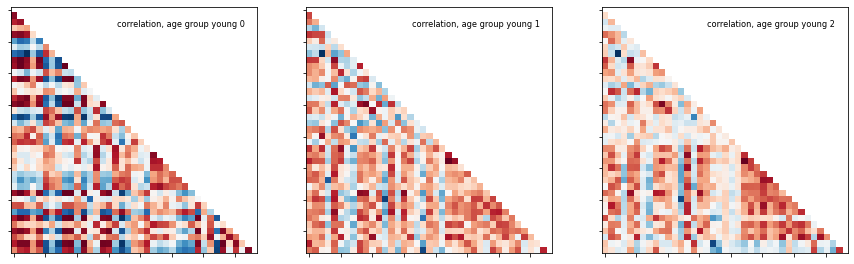

In [45]:
from nilearn import plotting
from matplotlib import pyplot as plt

_, axes = plt.subplots(1, 3, figsize = (15, 5))
for i, (matrix, ax) in enumerate(zip(correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri = 'lower', 
                         colorbar = False, 
                         axes = ax,
                         title = 'correlation, age group young {}'.format(i))

Now, display the mean correlation matrix of **all young people** as a functional connectome (i.e. collective set of functional connections in the brain). Use [`nilearn.plotting.plot_connectome`](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_connectome.html#nilearn.plotting.plot_connectome) to plot connectome on top of brain glass schematics. The plotted image should be in MNI space for this function to work properly. 

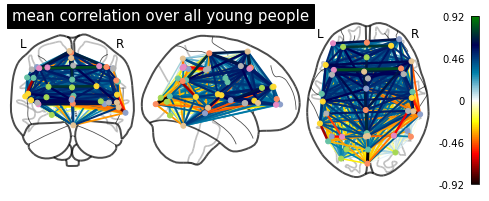

In [46]:
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         node_size = 25,
                         colorbar = True,
                         edge_cmap = 'ocean_hot_r',
                         title = 'mean correlation over all young people');

plt.savefig('functional connectome (full cor)_AgeGroup.png')

## Studying partial correlations
- `ConnectivityMeasure` for partial correlation was instantiated earlier as `partial_correlation_measure`. 

In [47]:
# fit measure to young people's data
partial_correlation_matrices = partial_correlation_measure.fit_transform(young)

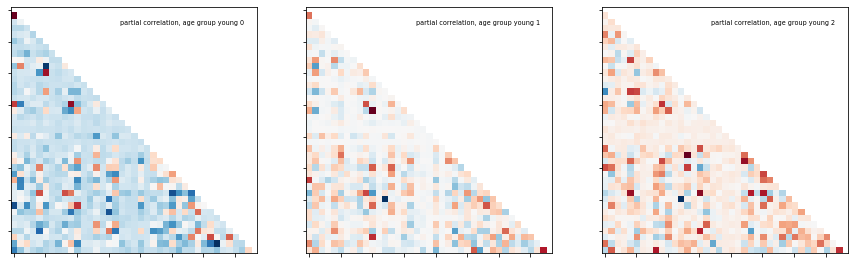

In [48]:
# plot correlation maps
_, axes = plt.subplots(1, 3, figsize = (15, 5))

for i, (matrix, ax) in enumerate(zip(partial_correlation_matrices, axes)):
    plotting.plot_matrix(matrix, tri = 'lower', 
                         colorbar = False, 
                         axes = ax,
                         title = 'partial correlation, age group young {}'.format(i))

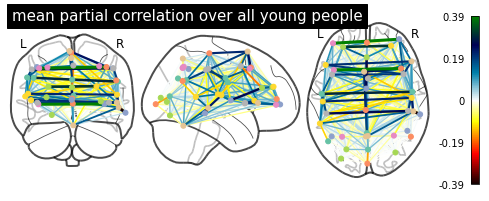

In [49]:
plotting.plot_connectome(partial_correlation_measure.mean_, msdl_coords,
                         node_size = 25,
                         colorbar = True,
                         edge_cmap = 'ocean_hot_r',
                         title = 'mean partial correlation over all young people');

plt.savefig('functional connectome (partial cor)_AgeGroup.png')

## Extract subjects variabilities around a group connectivity
- We can use both full correlations and partial correlations to capture reproducible connectivity patterns at the group level. This is done using **tangent space embedding**. 

Fit the young people's group and get the group connectivity matrix stored as means in `tangent_measure.mean_` and individual deviation matrices of each subject from it.

In [50]:
# fit to data
tangent_matrices = tangent_measure.fit_transform(young)

`tangent_matrices` model individual connectivities as **perturbations** of the group connectivity matrix (`tangent_measure.mean_`). These subject-to-group variability matrices do not directly reflect individual brain connections. For instance, negative coefficients can't be interpreted as anticorrelated regions. 

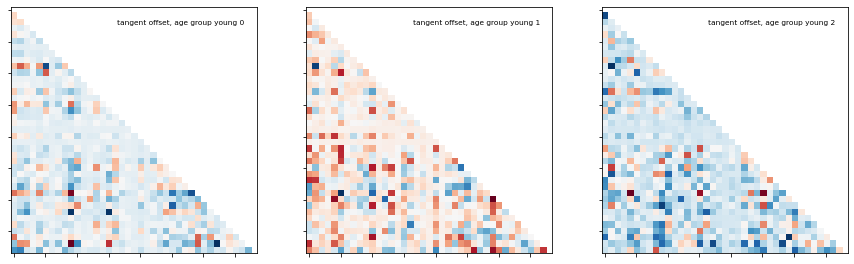

In [51]:
# plot
_, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (matrix, ax) in enumerate(zip(tangent_matrices, axes)):
    plotting.plot_matrix(matrix, 
                         tri='lower', 
                         colorbar=False, 
                         axes=ax,
                         title='tangent offset, age group young {}'.format(i))

## What kind of connectivity is most powerful for classfication?
- We will use connectivity matrices as features to distinguish age group young from old. 
- Use cross-validation and measure classification accuracy to compare the different kinds of connectivity matrices. 
- Use random splits of the subjects into training/testing sets. 
- [`StratifiedShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit), a cross validator from `sklearn`, allows preventing the proportion of young people in the test set.

In [60]:
_, classes = np.unique(groups_age, return_inverse = True)

cv = StratifiedShuffleSplit(n_splits = 15, # n of reshuffling & splitting iterations
                            random_state = 0, # controls the randomness of training & testing indices produced
                            # if float, proportion of dataset to include in the train split
                            # if int, absolute n of train samples
                            test_size = 10)

# transform list into np ndarray
pooled_subjects_age = np.asarray(pooled_subjects_age)

In [61]:
kinds = ['correlation', 'partial correlation', 'tangent']
scores = {}

for kind in kinds:
    # dictionary scores 
    # key is kind, value is empty 
    scores[kind] = []
    # cv was instantiated earlier as StratifiedShuffleSplit
    for train, test in cv.split(pooled_subjects_age, classes):
        # ConnectivityMeasure can output the estimated subjects coefficients
        # as 1D arrays through the parameter vectorize
        connectivity = ConnectivityMeasure(kind = kind, 
                                           vectorize = True)
        # build vectorized connectomes for subjects in the train set
        connectomes = connectivity.fit_transform(pooled_subjects_age[train])
        # fit the classifier
        classifier = LinearSVC().fit(connectomes, classes[train])
        # make predictions for the left-out test subjects
        predictions = classifier.predict(connectivity.transform(pooled_subjects_age[test]))
        # store the accuracy for this cross validation fold
        scores[kind].append(accuracy_score(classes[test], predictions))

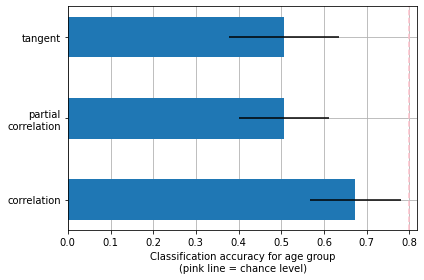

In [62]:
# display the results
mean_scores = [np.mean(scores[kind]) for kind in kinds]
scores_std = [np.std(scores[kind]) for kind in kinds]

plt.figure(figsize = (6, 4))
positions = np.arange(len(kinds))*.1 + .1
plt.barh(positions, mean_scores, align = 'center', height = .05, xerr = scores_std)
yticks = [k.replace(' ','\n') for k in kinds]
plt.yticks(positions, yticks)

# set current axes
plt.gca().grid(True)
plt.gca().set_axisbelow(True)
plt.gca().axvline(.8, color = 'pink', linestyle = '--')

plt.xlabel('Classification accuracy for age group\n(pink line = chance level)')
plt.tight_layout() # adjust padding between and around subplots

The finding from the original [nilearn example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) was not replicated. This could be due to technical differences in our datasets, sample size and train/test split or theoretical issues regarding whether resting-state functional connectivity really differs based on sex or age. Finally, note that the nilearn example contained a confound file for time-series data, which was not located in the current Sleepy Brain dataset.